# Sprint 2 Presentation

### Creating a Recommender Engine for SB19

In [162]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score,roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

%matplotlib inline

## Part 1. Recommender Engine Pool

### 1. Read the training data

In [163]:
genre_names = ['pop', 'k-pop', 'classical', 'lo-fi', 'r&b', 'TIKTOK']
#genre_names = ['pop', 'k-pop', 'classical', 'lo-fi', 'r&b', 'TIKTOK']

playlist_df_list = []
track_df_list = []
for genre in genre_names:
    # read and process the playlist data for keyword
    print(genre)
    pdf = pd.read_csv('data/'+genre.lower()+'_playlist_data.csv')
    pdf['genre'] = genre.lower().replace('&','n')
    #pdf['genre'] = genre.replace('TIKTOK PHILIPPINES','tiktok')
    playlist_df_list.append(pdf)

    tdf = pd.read_csv('data/'+genre.lower()+'_playlist_tracks_data.csv')
    tdf['genre'] = genre.lower().replace('&','n')
    #tdf['genre'] = genre.replace('TIKTOK PHILIPPINES','tiktok')
    tdf = tdf.drop(columns=['playlist_name'])
    tdf = tdf.merge(pdf[['playlist_id','playlist_name']], on=['playlist_id'], how='left')
    
    track_df_list.append(tdf)
    
    
        
playlist_df = pd.concat(playlist_df_list)
tracks_df = pd.concat(track_df_list)


pop
k-pop
classical
lo-fi
r&b
TIKTOK


In [164]:
tracks_df['genre'].value_counts()

lo-fi        4128
classical    2441
tiktok       1725
pop          1651
k-pop        1091
rnb          1058
Name: genre, dtype: int64

In [165]:
#check shape
playlist_df.shape, tracks_df.shape

((462, 7), (12094, 22))

In [166]:
#check columns
print("Playlist dataset columns: %s \n" % playlist_df.columns.values)
print("Tracks dataset columns: %s" % tracks_df.columns.values)

Playlist dataset columns: ['playlist_id' 'playlist_name' 'playlist_total_tracks' 'owner_id'
 'owner_name' 'total_followers' 'genre'] 

Tracks dataset columns: ['track_id' 'track_name' 'artist_id' 'artist_name' 'album_id' 'duration'
 'release_date' 'popularity' 'danceability' 'energy' 'key' 'loudness'
 'mode' 'speechiness' 'acousticness' 'instrumentalness' 'liveness'
 'valence' 'tempo' 'playlist_id' 'genre' 'playlist_name']


In [167]:
#check null rows
playlist_df[playlist_df.isnull().any(1)]
#tracks_df[tracks_df.isnull().any(1)]


,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre


In [168]:
#remove null rows
#tracks_df = tracks_df.dropna()
tracks_df.shape

(12094, 22)

In [169]:
# How many unique tracks are in the combined dataset?
len(tracks_df['track_id'].unique())

11890

In [170]:
#retain only distinct tracks per keyword
#tracks_df = tracks_df.drop_duplicates(subset='track_id')
tracks_df.shape

(12094, 22)

In [171]:
#tally of tracks
#tracks_df['genre'].value_counts()
tracks_df['genre'].value_counts(normalize=True)

lo-fi        0.341326
classical    0.201836
tiktok       0.142633
pop          0.136514
k-pop        0.090210
rnb          0.087481
Name: genre, dtype: float64

### 2. Refine the training data

In [172]:
#get top 5 playlists per genre
top_playlists_df = playlist_df.groupby('genre').head(5)
top_playlists_df

,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre
0,37i9dQZF1DWTwnEm1IYyoj,Soft Pop Hits,232,spotify,Spotify,4735038,pop
1,37i9dQZF1DX50QitC6Oqtn,Love Pop,100,spotify,Spotify,3258215,pop
2,37i9dQZF1DXcZDD7cfEKhW,Pop Remix,50,spotify,Spotify,3214947,pop
3,37i9dQZF1DX6aTaZa0K6VA,Pop Up,80,spotify,Spotify,3008206,pop
4,37i9dQZF1DX9tPFwDMOaN1,K-Pop Daebak,50,spotify,Spotify,2780993,pop
0,37i9dQZF1DX9tPFwDMOaN1,K-Pop Daebak,50,spotify,Spotify,2965156,k-pop
1,37i9dQZF1DX5CHqBODmn2c,Best of 2018: K-Pop,100,spotify,Spotify,708053,k-pop
2,37i9dQZF1DX4FcAKI5Nhzq,K-Pop Rising,72,spotify,Spotify,545797,k-pop
3,37i9dQZF1DX6Cy4Vr7Hu2y,Women of K-Pop,64,spotify,Spotify,509249,k-pop
4,37i9dQZF1DX4IDaXtVjL83,K-Pop X-Overs,50,spotify,Spotify,383878,k-pop


In [173]:
#tracks_df = tracks_df[tracks_df['playlist_id'].isin(top_playlists_df['playlist_id'].values)]
tracks_df['genre'].value_counts()

lo-fi        4128
classical    2441
tiktok       1725
pop          1651
k-pop        1091
rnb          1058
Name: genre, dtype: int64

### 3. Feature Engineering

###### Categorical Encoding

In [174]:
tracks_df["genre"] = tracks_df["genre"].astype('category')
tracks_df.dtypes

track_id              object
track_name            object
artist_id             object
artist_name           object
album_id              object
duration               int64
release_date          object
popularity             int64
danceability         float64
energy               float64
key                    int64
loudness             float64
mode                   int64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
playlist_id           object
genre               category
playlist_name         object
dtype: object

In [175]:
tracks_df['genre'].value_counts()

lo-fi        4128
classical    2441
tiktok       1725
pop          1651
k-pop        1091
rnb          1058
Name: genre, dtype: int64

In [176]:
tracks_df['genre_id'] = tracks_df["genre"].cat.codes
tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,genre,playlist_name,genre_id
0,1EzrEOXmMH3G43AXT1y7pA,I'm Yours,4phGZZrJZRo4ElhRtViYdl,Jason Mraz,04G0YylSjvDQZrjOfE5jA5,242186,2008-05-12,83,0.686,0.457,...,0.0468,0.595,0.0,0.1050,0.718,150.953,37i9dQZF1DWTwnEm1IYyoj,pop,Soft Pop Hits,3
1,2b8fOow8UzyDFAE27YhOZM,Memories,04gDigrS5kc9YWfZHwBETP,Maroon 5,3nR9B40hYLKLcR0Eph3Goc,189486,2019-09-20,90,0.764,0.320,...,0.0546,0.837,0.0,0.0822,0.575,91.019,37i9dQZF1DWTwnEm1IYyoj,pop,Soft Pop Hits,3
2,2TIlqbIneP0ZY1O0EzYLlc,Someone You Loved,4GNC7GD6oZMSxPGyXy4MNB,Lewis Capaldi,0NVQ9k3wKmuK6T02lLMl6y,182160,2018-11-08,81,0.501,0.405,...,0.0319,0.751,0.0,0.1050,0.446,109.891,37i9dQZF1DWTwnEm1IYyoj,pop,Soft Pop Hits,3
3,0tgVpDi06FyKpA1z0VMD4v,Perfect,6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,3T4tUhGYeRNVUGevb0wThu,263400,2017-03-03,88,0.599,0.448,...,0.0232,0.163,0.0,0.1060,0.168,95.050,37i9dQZF1DWTwnEm1IYyoj,pop,Soft Pop Hits,3
4,6QfS2wq5sSC1xAJCQsTSlj,Shallow - Radio Edit,1HY2Jd0NmPuamShAr6KMms,Lady Gaga,3edjzMAVB9RYRd4UcZBchx,217212,2018-10-05,78,0.575,0.330,...,0.0310,0.416,0.0,0.0872,0.277,95.801,37i9dQZF1DWTwnEm1IYyoj,pop,Soft Pop Hits,3


In [177]:
genre_lookup = dict(tracks_df.groupby('genre_id').head(1)[['genre_id','genre']].values)
genre_lookup

{3: 'pop', 1: 'k-pop', 0: 'classical', 2: 'lo-fi', 4: 'rnb', 5: 'tiktok'}

##### Conversions/Normalizations

In [178]:
#convert duration from ms to mins
tracks_df['duration_mins']=tracks_df['duration']/60000

In [179]:
tracks_df['loudness'] = scaler.fit_transform(tracks_df[['loudness']])
tracks_df['loudness'].describe()

count    12094.000000
mean         0.740283
std          0.153496
min          0.000000
25%          0.664833
50%          0.775056
75%          0.856363
max          1.000000
Name: loudness, dtype: float64

In [180]:
#Normalize tempo
tracks_df['tempo'] =  scaler.fit_transform(tracks_df[['tempo']])
#check
tracks_df['tempo'].describe()


count    12094.000000
mean         0.470544
std          0.133434
min          0.000000
25%          0.354611
50%          0.454848
75%          0.563518
max          1.000000
Name: tempo, dtype: float64

## 4A. Train a KNN model

In [181]:
#test plot for a genre and 2 predictors

#fig = plt.figure()
#ax= fig.add_subplot(111)

#colormaps = ['Reds','Blues']
#genre = 'pop'
#label = ["not "+genre,genre]
#for n,genre_bool in enumerate([0,1]):
#    df=tracks_df[tracks_df['genre_'+genre]==genre_bool]
#    sns.kdeplot(df['energy'],df['tempo'], ax=ax,\
#                shade=True, shade_lowest=False, alpha=0.5, cmap=colormaps[n],\
#                label=label[n])
    
#plt.legend(frameon=False)


Tuning the model


Tuning kNN classification model with K-Fold=4...
Shape of X_Train:(9675, 8)
Shape of y_Train:(9675,)
Shape of X_Test:(2419, 8)
Shape of y_Test:(2419,)
Finding best k...


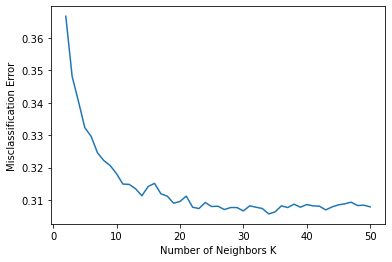

The optimal number of neighbors is 34 with score 69%

Tuning kNN classification model with K-Fold=5...
Shape of X_Train:(9675, 8)
Shape of y_Train:(9675,)
Shape of X_Test:(2419, 8)
Shape of y_Test:(2419,)
Finding best k...


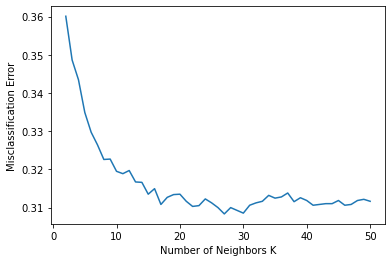

The optimal number of neighbors is 27 with score 69%

Tuning kNN classification model with K-Fold=8...
Shape of X_Train:(9675, 8)
Shape of y_Train:(9675,)
Shape of X_Test:(2419, 8)
Shape of y_Test:(2419,)
Finding best k...


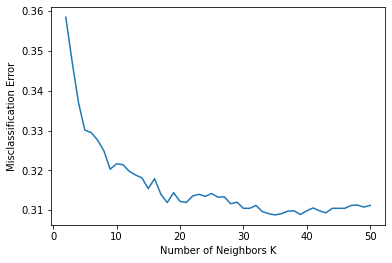

The optimal number of neighbors is 35 with score 69%

Tuning kNN classification model with K-Fold=10...
Shape of X_Train:(9675, 8)
Shape of y_Train:(9675,)
Shape of X_Test:(2419, 8)
Shape of y_Test:(2419,)
Finding best k...


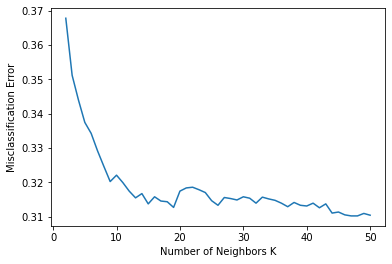

The optimal number of neighbors is 47 with score 68%


In [182]:
#Select audio features to use for the model
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
                'valence', 'tempo']
#'liveness', 

results_optimal_k = []

kfolds= [4,5,8,10]

for d in kfolds:
    print('\nTuning kNN classification model with K-Fold=%d...' % d)
    # create feature matrix (X)
    X = tracks_df[feature_cols]
    y = tracks_df['genre_id']

    # creating training set, test set and checking shapes 
    X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size=0.2)
    print("Shape of X_Train:"+str(X_train.shape))
    print("Shape of y_Train:"+str(Y_train.shape))
    print("Shape of X_Test:"+str(X_test.shape))
    print("Shape of y_Test:"+str(Y_test.shape))
    
    #train model
    cv_scores = []
    neighbors=np.arange(2,51)
    print('Finding best k...')
    
    #Perform KNN using K= [1..50] and validate using k-fold k = 5
    for k in neighbors:
        #print('Fitting for k=%d' % k)
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, Y_train, cv=5, scoring='accuracy')
        cv_scores.append(scores.mean())
        
    # changeto misclassification error
    mse = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[mse.index(min(mse))]
    results_optimal_k.append(optimal_k)
    
    knn_optimal = KNeighborsClassifier(n_neighbors=k)
    knn_optimal.fit(X, y)
    # plot misclassification error vs k
    plt.plot(neighbors, mse)
    plt.xlabel("Number of Neighbors K")
    plt.ylabel("Misclassification Error")
    plt.show()
    
    print("The optimal number of neighbors is %d with score %d%%" % (optimal_k, 100*(1-min(mse))))


In [183]:
#results_optimal_k = [38, 33, 17, 21, 13, 46, 26, 27, 10, 26]
results_optimal_k

[34, 27, 35, 47]

In [184]:
for k in results_optimal_k:
    
    X = tracks_df[feature_cols]
    y = tracks_df['genre_id']

    # creating training set, test set and checking shapes 
    X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size=0.2)
    
    knn = KNeighborsClassifier(n_neighbors=k)
        
    # fitting the model
    knn_optimal.fit(X_train, Y_train)

    # predict the response
    pred = knn_optimal.predict(X_test)

    # evaluate accuracy
    acc = accuracy_score(Y_test, pred) * 100
    print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (k, acc))
    print(classification_report(y,knn_optimal.predict(X)))


The accuracy of the knn classifier for k = 34 is 67.879289%
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      2441
           1       0.50      0.52      0.51      1091
           2       0.91      0.90      0.91      4128
           3       0.41      0.70      0.52      1651
           4       0.44      0.18      0.25      1058
           5       0.53      0.39      0.45      1725

    accuracy                           0.70     12094
   macro avg       0.62      0.60      0.59     12094
weighted avg       0.71      0.70      0.70     12094


The accuracy of the knn classifier for k = 27 is 69.243489%
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      2441
           1       0.50      0.53      0.51      1091
           2       0.91      0.90      0.91      4128
           3       0.41      0.69      0.52      1651
           4       0.44      0.17      0.24      1058
          

## 4B. Train a SVM model

In [185]:
from sklearn.svm import SVC

In [186]:
# https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html#sphx-glr-auto-examples-svm-plot-iris-svc-py
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    xmgn= (x.max()-x.min())*0.25
    ymgn = (y.max()-y.min())*0.25
    
    x_min, x_max = x.min() - xmgn, x.max() + xmgn
    y_min, y_max = y.min() - ymgn, y.max() + ymgn
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, xlims,ylims, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    ax.set_ylim(ylims)
    ax.set_xlim(xlims)
    
    return out

#visualize support vectors
def plot_vector_bounds(X,svm_model):
    fig,ax=plt.subplots()

    X0 = X.to_numpy()[:, 0]
    X1 = X.to_numpy()[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    plot_contours(ax, svm_model, xx, yy, [0,1],[0,1],
                      cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y,cmap=plt.cm.coolwarm, s=20, edgecolors='k')

In [187]:
# create feature matrix (X)
X = tracks_df[feature_cols]
y = tracks_df['genre_id']

# creating training set, test set and checking shapes 
X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size=0.2)
print("Shape of X_Train:"+str(X_train.shape))
print("Shape of y_Train:"+str(Y_train.shape))
print("Shape of X_Test:"+str(X_test.shape))
print("Shape of y_Test:"+str(Y_test.shape))

Shape of X_Train:(9675, 8)
Shape of y_Train:(9675,)
Shape of X_Test:(2419, 8)
Shape of y_Test:(2419,)


In [188]:
svm_model1 = SVC(kernel='linear')
pred1 = svm_model1.fit(X, y)
print(classification_report(y,svm_model1.predict(X)))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90      2441
           1       0.50      0.50      0.50      1091
           2       0.90      0.90      0.90      4128
           3       0.43      0.63      0.51      1651
           4       0.60      0.00      0.01      1058
           5       0.43      0.51      0.47      1725

    accuracy                           0.69     12094
   macro avg       0.63      0.57      0.55     12094
weighted avg       0.71      0.69      0.67     12094



In [189]:
svm_model2 = SVC(kernel='poly', degree=6, coef0 = 1.0, gamma=0.8)
pred2 = svm_model2.fit(X, y) 
print(classification_report(y,svm_model2.predict(X)))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2441
           1       0.58      0.54      0.56      1091
           2       0.93      0.94      0.93      4128
           3       0.48      0.69      0.57      1651
           4       0.49      0.24      0.33      1058
           5       0.55      0.50      0.52      1725

    accuracy                           0.75     12094
   macro avg       0.66      0.64      0.64     12094
weighted avg       0.75      0.75      0.74     12094



In [190]:
svm_model3 = SVC(kernel='rbf', gamma=0.8)
pred3 = svm_model3.fit(X, y)
print(classification_report(y,svm_model3.predict(X)))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      2441
           1       0.55      0.46      0.50      1091
           2       0.91      0.92      0.91      4128
           3       0.42      0.69      0.52      1651
           4       0.51      0.11      0.18      1058
           5       0.48      0.48      0.48      1725

    accuracy                           0.71     12094
   macro avg       0.63      0.59      0.58     12094
weighted avg       0.72      0.71      0.70     12094



### 5. Model Prediction

In [191]:
#Predict genres of the charting tracks
chart_tracks_df = pd.read_csv("data/spotify_daily_charts_tracks.csv")
chart_tracks_df = chart_tracks_df.dropna()
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0kN8xEmgMW9mh7UmDYHlJP,Versace on the Floor,0du5cEVh5yTK9QJze8zA0C,Bruno Mars,4PgleR09JVnm3zY1fW3XBA,261240,2016-11-17,76,0.578,0.574,2.0,-6.209,1.0,0.0454,0.196,0.00000,0.0830,0.301,174.152
1,5uCax9HTNlzGybIStD3vDh,Say You Won't Let Go,4IWBUUAFIplrNtaOHcJPRM,James Arthur,7oiJYvEJHsmYtrgviAVIBD,211466,2016-10-28,85,0.358,0.557,10.0,-7.398,1.0,0.0590,0.695,0.00000,0.0902,0.494,85.043
2,7BKLCZ1jbUBVqRi2FVlTVw,Closer,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0rSLgV8p5FzfnqlEk4GzxE,244960,2016-07-29,85,0.748,0.524,8.0,-5.599,1.0,0.0338,0.414,0.00000,0.1110,0.661,95.010
3,2rizacJSyD9S1IQUxUxnsK,All We Know,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0xmaV6EtJ4M3ebZUPRnhyb,194080,2016-09-29,69,0.662,0.586,0.0,-8.821,1.0,0.0307,0.097,0.00272,0.1150,0.296,90.000
4,5MFzQMkrl1FOOng9tq6R9r,Don't Wanna Know,04gDigrS5kc9YWfZHwBETP,Maroon 5,0fvTn3WXF39kQs9i3bnNpP,214480,2016-10-11,0,0.783,0.623,7.0,-6.126,1.0,0.0800,0.338,0.00000,0.0975,0.447,100.048


In [228]:
sb19_id = chart_tracks_df[chart_tracks_df['artist_name']=='SB19']['track_id'].unique()
chart_tracks_df[chart_tracks_df['artist_name']=='SB19']

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,predicted_classical_prob,predicted_k-pop_prob,predicted_lo-fi_prob,predicted_pop_prob,predicted_rnb_prob,predicted_tiktok_prob,euclidean_dist,manhattan_dist,cosine_dist,cosine_dist_mod
751,5p70OUKixtLRpnK5uSdqro,Love Goes,3g7vYcdDXnqnDKYFwqXBJP,SB19,4JlsfnNH8MCDXR0ypy1zcm,221544,2020-07-31,46,0.714,0.663,...,0.003979,0.001191,0.052717,0.130715,0.455123,0.356276,0.153,0.153,6.531382e-02,0.118881
1305,0LAh3hfeuUekvLm3Nq6MmA,Love Goes - EDM Version,3g7vYcdDXnqnDKYFwqXBJP,SB19,4JlsfnNH8MCDXR0ypy1zcm,215000,2020-07-31,44,0.718,0.780,...,0.005751,0.018872,0.165420,0.138647,0.172708,0.498602,0.157,0.157,3.670912e-02,0.085918
1644,2WUhR1SraSy0SVIQKohJb6,Hanggang Sa Huli,3g7vYcdDXnqnDKYFwqXBJP,SB19,4JlsfnNH8MCDXR0ypy1zcm,254469,2020-07-31,55,0.539,0.553,...,0.008289,0.039411,0.061547,0.182884,0.480276,0.227594,0.022,0.022,1.667447e-01,0.198585
1761,053ZzdU3Rya4NMxiWMPqnq,Alab (Burning),3g7vYcdDXnqnDKYFwqXBJP,SB19,4JlsfnNH8MCDXR0ypy1zcm,182750,2020-07-31,48,0.715,0.927,...,0.114315,0.007254,0.563579,0.026039,0.111241,0.177572,0.154,0.154,2.575482e-02,0.121142
1773,3fNpKcMrEDrnjahY9kN5fQ,Alab (Burning),3g7vYcdDXnqnDKYFwqXBJP,SB19,3twC225hfx6FrfrGAO3zvF,182750,2019-12-25,46,0.715,0.927,...,0.011525,0.077784,0.056755,0.124148,0.320674,0.409114,0.154,0.154,2.581667e-02,0.069534
2768,5VoY18OYEE2E6RJCBd2jki,Go Up,3g7vYcdDXnqnDKYFwqXBJP,SB19,4JlsfnNH8MCDXR0ypy1zcm,189047,2020-07-31,51,0.702,0.941,...,0.010718,0.017943,0.054158,0.098531,0.518325,0.300325,0.141,0.141,4.218862e-02,0.099856
2822,5Gm6YoDs8N2WznOpASSB5P,Go Up,3g7vYcdDXnqnDKYFwqXBJP,SB19,7cnW5rl7F9OkVxqbcJPNCq,189100,2019-07-19,0,0.704,0.944,...,0.003001,0.050466,0.175877,0.272120,0.234099,0.264437,0.143,0.143,4.346168e-02,0.064775
2884,6KawczP7xc6xQRIpOqvpey,Tilaluha,3g7vYcdDXnqnDKYFwqXBJP,SB19,4JlsfnNH8MCDXR0ypy1zcm,237428,2020-07-31,50,0.463,0.456,...,0.013836,0.026778,0.075079,0.145070,0.432637,0.306599,0.098,0.098,2.347488e-01,0.260792
3204,4sYZHEiueAYM5klpUbVNyk,What?,3g7vYcdDXnqnDKYFwqXBJP,SB19,18g914rk7rcJP0o4uhz8uE,270192,2021-03-09,60,0.561,0.856,...,0.012355,0.165386,0.014057,0.511190,0.110455,0.186556,0.000,0.000,1.110223e-16,0.000000


In [193]:
#normalize loudness and tempo
chart_tracks_df['loudness'] = scaler.fit_transform(chart_tracks_df[['loudness']])
chart_tracks_df['tempo'] =  scaler.fit_transform(chart_tracks_df[['tempo']])

Test the model with external data by predicting the genres of the spotify charting tracks!

In [194]:
#Predict genres of the spotify charts
genres = [genre_lookup[i] for i in np.arange(len(genre_names))]

#n=3 #pick kfold=10
#print("Predicting with optimal k: %d" %(results_optimal_k[n]))

svm_model2 = SVC(kernel='poly', degree=6, coef0 = 1.0, gamma=0.8, probability=True)
X = tracks_df[feature_cols]
y = tracks_df['genre_id']
pred2 = svm_model2.fit(X, y) 

chart_tracks_df['predicted_genre_id'] = chart_tracks_df.apply(lambda x:  pred2.predict(x[feature_cols].values.reshape(1,-1))[0]\
                                               , axis=1)
chart_tracks_df['predicted_genre'] = chart_tracks_df['predicted_genre_id'].apply(lambda x: genre_lookup[x])
chart_tracks_df['predicted_genre_prob'] = chart_tracks_df.apply(lambda x:  np.max(pred2.predict_proba(x[feature_cols].values.reshape(1,-1)))\
                                                    , axis=1)
chart_tracks_df['all_genre_prob'] = chart_tracks_df.apply(lambda x:  pred2.predict_proba(x[feature_cols].values.reshape(1,-1))[0]\
                                                    , axis=1)


In [195]:
#explode genre probabilities into separate columns
charts_predicted_genre_prob = pd.DataFrame(chart_tracks_df["all_genre_prob"].to_list(),
                                           columns=['predicted_'+g+'_prob' for g in genres])
charts_predicted_genre_prob['track_id'] = chart_tracks_df['track_id']
chart_tracks_df = pd.merge(chart_tracks_df,charts_predicted_genre_prob, how='left', on='track_id')
chart_tracks_df = chart_tracks_df.drop(columns='all_genre_prob')
chart_tracks_df = chart_tracks_df.sort_values('predicted_genre_prob', ascending=False)
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_classical_prob,predicted_k-pop_prob,predicted_lo-fi_prob,predicted_pop_prob,predicted_rnb_prob,predicted_tiktok_prob
2484,3ClBKQkKoaUQ6UOhe2xlJK,Good News,4LLpKhyESsyAXpc4laK94U,Mac Miller,4CCaoRnCugI6RsHHBKiMLs,342040,2020-01-09,64,0.794,0.320,...,0.747708,2,lo-fi,0.999947,0.907846,0.000395,0.076770,0.000633,0.002729,0.011628
2493,1DWZUa5Mzf2BwzpHtgbHPY,Good News,4LLpKhyESsyAXpc4laK94U,Mac Miller,5sY6UIQ32GqwMLAfSNEaXb,342040,2020-01-17,76,0.794,0.320,...,0.747708,2,lo-fi,0.999947,0.016431,0.000663,0.706495,0.001639,0.065962,0.208810
1856,2L9QLAhrvtP4EYg1lY0Tnw,Rudolph The Red-Nosed Reindeer,49e4v89VmlDcFCMyDv9wQ9,Dean Martin,5I48ENiZiaZZSOpec6PdS5,135760,1959-01-01,41,0.478,0.201,...,0.516244,0,classical,0.999908,0.008544,0.055373,0.495946,0.032465,0.367855,0.039816
2226,6VnqGxiMNexOe0kRmIsBw4,Ain't Nobody Takin My Baby,1z7b1Pr1rSlvWRzsW3HOrS,Russ,507vscnpu2fPaKmA5nC3pX,189231,2016-12-23,69,0.696,0.570,...,0.150162,2,lo-fi,0.999490,0.012575,0.025377,0.002484,0.217251,0.259473,0.482840
2006,4SSnFejRGlZikf02HLewEF,bury a friend,6qqNVTkY8uBg9cP3Jd7DAH,Billie Eilish,0S0KGZnfBGSIssfF54WSJh,193143,2019-03-29,79,0.905,0.389,...,0.415179,2,lo-fi,0.999046,0.479466,0.000627,0.496184,0.000764,0.005723,0.017237


Check out tracks with highest assigned probability

In [196]:
chart_tracks_df.groupby('predicted_genre_id').head()[['artist_name','track_name','predicted_genre','predicted_genre_prob']]

,artist_name,track_name,predicted_genre,predicted_genre_prob
2484,Mac Miller,Good News,lo-fi,0.999947
2493,Mac Miller,Good News,lo-fi,0.999947
1856,Dean Martin,Rudolph The Red-Nosed Reindeer,classical,0.999908
2226,Russ,Ain't Nobody Takin My Baby,lo-fi,0.999490
2006,Billie Eilish,bury a friend,lo-fi,0.999046
1923,Billie Eilish,bury a friend,lo-fi,0.999046
1824,Dean Martin,Let It Snow! Let It Snow! Let It Snow!,classical,0.998726
1847,Elvis Presley,Blue Christmas,classical,0.998407
2975,Jose Mari Chan,A Wish On Christmas Night,classical,0.997260
1014,Frank Sinatra,Jingle Bells (with The Ken Lane Singers),classical,0.996128


View histogram of predicted genre probabilities

<AxesSubplot:>

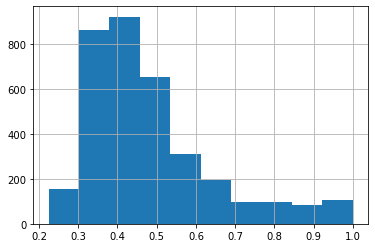

In [197]:
chart_tracks_df['predicted_genre_prob'].hist()

Check out tally of predicted genres

In [198]:
chart_tracks_df['predicted_genre'].value_counts()

rnb          914
tiktok       875
pop          842
lo-fi        573
classical    229
k-pop         56
Name: predicted_genre, dtype: int64

In [199]:
chart_tracks_df.columns

Index(['track_id', 'track_name', 'artist_id', 'artist_name', 'album_id',
       'duration', 'release_date', 'popularity', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo',
       'predicted_genre_id', 'predicted_genre', 'predicted_genre_prob',
       'predicted_classical_prob', 'predicted_k-pop_prob',
       'predicted_lo-fi_prob', 'predicted_pop_prob', 'predicted_rnb_prob',
       'predicted_tiktok_prob'],
      dtype='object')

In [200]:
genre_lookup

{3: 'pop', 1: 'k-pop', 0: 'classical', 2: 'lo-fi', 4: 'rnb', 5: 'tiktok'}

In [201]:
chart_tracks_df[chart_tracks_df['track_id'].isin(sb19_id)][['track_id', 'track_name','artist_name', 'predicted_genre_id', 'predicted_genre', 'predicted_genre_prob',
       'predicted_classical_prob', 'predicted_k-pop_prob',
       'predicted_lo-fi_prob', 'predicted_pop_prob', 'predicted_rnb_prob',
       'predicted_tiktok_prob']].sort_values('predicted_tiktok_prob', ascending=False)

,track_id,track_name,artist_name,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_classical_prob,predicted_k-pop_prob,predicted_lo-fi_prob,predicted_pop_prob,predicted_rnb_prob,predicted_tiktok_prob
2929,0LAh3hfeuUekvLm3Nq6MmA,Love Goes - EDM Version,SB19,4,rnb,0.480276,0.005751,0.018872,0.165420,0.138647,0.172708,0.498602
2452,3fNpKcMrEDrnjahY9kN5fQ,Alab (Burning),SB19,1,k-pop,0.438289,0.011525,0.077784,0.056755,0.124148,0.320674,0.409114
2928,5p70OUKixtLRpnK5uSdqro,Love Goes,SB19,4,rnb,0.562892,0.003979,0.001191,0.052717,0.130715,0.455123,0.356276
2927,6KawczP7xc6xQRIpOqvpey,Tilaluha,SB19,3,pop,0.345589,0.013836,0.026778,0.075079,0.145070,0.432637,0.306599
2926,5VoY18OYEE2E6RJCBd2jki,Go Up,SB19,3,pop,0.355040,0.010718,0.017943,0.054158,0.098531,0.518325,0.300325
2296,5Gm6YoDs8N2WznOpASSB5P,Go Up,SB19,3,pop,0.351428,0.003001,0.050466,0.175877,0.272120,0.234099,0.264437
2924,2WUhR1SraSy0SVIQKohJb6,Hanggang Sa Huli,SB19,3,pop,0.448357,0.008289,0.039411,0.061547,0.182884,0.480276,0.227594
3333,4sYZHEiueAYM5klpUbVNyk,What?,SB19,4,rnb,0.317251,0.012355,0.165386,0.014057,0.511190,0.110455,0.186556
2925,053ZzdU3Rya4NMxiWMPqnq,Alab (Burning),SB19,1,k-pop,0.439313,0.114315,0.007254,0.563579,0.026039,0.111241,0.177572
3484,6Fz2TpxUD0YvAPsuG8nDMJ,MAPA,SB19,3,pop,0.451822,NaN,NaN,NaN,NaN,NaN,NaN


In [202]:
chart_tracks_df[chart_tracks_df['track_id'].isin(sb19_id)][['track_name','artist_name', 'predicted_genre', 'predicted_genre_prob',
       'predicted_k-pop_prob', 'predicted_pop_prob', 'predicted_rnb_prob',
       'predicted_tiktok_prob']].sort_values('predicted_tiktok_prob', ascending=False)

,track_name,artist_name,predicted_genre,predicted_genre_prob,predicted_k-pop_prob,predicted_pop_prob,predicted_rnb_prob,predicted_tiktok_prob
2929,Love Goes - EDM Version,SB19,rnb,0.480276,0.018872,0.138647,0.172708,0.498602
2452,Alab (Burning),SB19,k-pop,0.438289,0.077784,0.124148,0.320674,0.409114
2928,Love Goes,SB19,rnb,0.562892,0.001191,0.130715,0.455123,0.356276
2927,Tilaluha,SB19,pop,0.345589,0.026778,0.145070,0.432637,0.306599
2926,Go Up,SB19,pop,0.355040,0.017943,0.098531,0.518325,0.300325
2296,Go Up,SB19,pop,0.351428,0.050466,0.272120,0.234099,0.264437
2924,Hanggang Sa Huli,SB19,pop,0.448357,0.039411,0.182884,0.480276,0.227594
3333,What?,SB19,rnb,0.317251,0.165386,0.511190,0.110455,0.186556
2925,Alab (Burning),SB19,k-pop,0.439313,0.007254,0.026039,0.111241,0.177572
3484,MAPA,SB19,pop,0.451822,NaN,NaN,NaN,NaN


In [203]:
sb19_tiktok_song = chart_tracks_df[chart_tracks_df['track_id'].isin(sb19_id)].sort_values('predicted_tiktok_prob', ascending=False).head(1)['track_id'].values
sb19_tiktok_song

array(['0LAh3hfeuUekvLm3Nq6MmA'], dtype=object)

In [204]:
#save data
chart_tracks_df.to_csv("data/spotify_daily_charts_tracks_predicted_genres.csv", index=False, encoding='utf-8')

## Part 2. Recommender Engine

In [205]:
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']

### Recommender Engine 1: SB-19's New Sound
#### Audio features only

In [206]:
"""#read data
chart_tracks_df=pd.read_csv("data/spotify_daily_charts_tracks.csv")
chart_tracks_df = chart_tracks_df.dropna()
#normalize loudness and tempo
scaler = MinMaxScaler()
chart_tracks_df['loudness'] = scaler.fit_transform(chart_tracks_df[['loudness']])
chart_tracks_df['tempo'] =  scaler.fit_transform(chart_tracks_df[['tempo']])
chart_tracks_df.head()"""

'#read data\nchart_tracks_df=pd.read_csv("data/spotify_daily_charts_tracks.csv")\nchart_tracks_df = chart_tracks_df.dropna()\n#normalize loudness and tempo\nscaler = MinMaxScaler()\nchart_tracks_df[\'loudness\'] = scaler.fit_transform(chart_tracks_df[[\'loudness\']])\nchart_tracks_df[\'tempo\'] =  scaler.fit_transform(chart_tracks_df[[\'tempo\']])\nchart_tracks_df.head()'

In [207]:
#seed track is Vibe With Me by Matthaios

seed_track_data = chart_tracks_df[chart_tracks_df['track_name']=='Vibe With Me'].iloc[0]
seed_track_data[feature_cols]

danceability           0.817
energy                 0.297
loudness            0.432139
speechiness           0.0553
acousticness           0.722
instrumentalness         0.0
liveness               0.101
valence                0.443
tempo               0.292023
Name: 2466, dtype: object

In [208]:
#compute euclidean distances, audio features only

chart_tracks_df['euclidean_dist'] = chart_tracks_df.apply(lambda x: euclidean_distances(x[feature_cols].values.reshape(-1, 1),\
                                                                  seed_track_data[feature_cols].values.reshape(-1, 1))\
                                                                  .flatten()[0], axis=1)
#get top 10 nearest to seed_track_data
recommendation_df = chart_tracks_df[chart_tracks_df['track_id']!=seed_track_data['track_id']].sort_values('euclidean_dist')[:10]
recommendation_df[['track_name','artist_name','euclidean_dist']+feature_cols]

,track_name,artist_name,euclidean_dist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
2860,Telephone,EXO-SC,0.000,0.817,0.640,0.872999,0.0487,0.23200,0.000000,0.2040,0.772,0.230116
2407,Own It (feat. Ed Sheeran & Burna Boy),Stormzy,0.000,0.817,0.781,0.821781,0.1120,0.00838,0.000005,0.1230,0.359,0.316445
1683,MIA (feat. Drake),Bad Bunny,0.000,0.817,0.539,0.732897,0.0621,0.01410,0.000496,0.0990,0.158,0.273754
3018,Backyard Boy,Claire Rosinkranz,0.000,0.817,0.634,0.696172,0.1620,0.32100,0.000000,0.0735,0.453,0.525745
2849,Telephone,EXO-SC,0.000,0.817,0.640,0.872999,0.0487,0.23200,0.000000,0.2040,0.772,0.230116
1099,Stir Fry,Migos,0.000,0.817,0.816,0.771668,0.2690,0.00263,0.000000,0.1590,0.508,0.796281
93,My Way,Calvin Harris,0.001,0.818,0.913,0.867554,0.0426,0.09300,0.000037,0.1610,0.536,0.414809
5,24K Magic,Bruno Mars,0.001,0.818,0.803,0.817523,0.0797,0.03400,0.000000,0.1530,0.632,0.334720
1296,Nadarang - Campfire Mix,Kyle Juliano,0.001,0.816,0.539,0.655189,0.0378,0.76500,0.000008,0.1020,0.456,0.402940
2781,MAKE ME GO,TWICE,0.001,0.818,0.633,0.864074,0.0611,0.00539,0.001740,0.0446,0.814,0.362698


In [209]:
#compute manhattan distances, audio features only

chart_tracks_df['manhattan_dist'] = chart_tracks_df.apply(lambda x: manhattan_distances(x[feature_cols].values.reshape(-1, 1),\
                                                                  seed_track_data[feature_cols].values.reshape(-1, 1))\
                                                                  .flatten()[0], axis=1)
#get top 10 nearest to seed_track_data
recommendation_df = chart_tracks_df[chart_tracks_df['track_id']!=seed_track_data['track_id']].sort_values('manhattan_dist')[:10]
recommendation_df[['track_name','artist_name','manhattan_dist']+feature_cols]

,track_name,artist_name,manhattan_dist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
2860,Telephone,EXO-SC,0.000,0.817,0.640,0.872999,0.0487,0.23200,0.000000,0.2040,0.772,0.230116
2407,Own It (feat. Ed Sheeran & Burna Boy),Stormzy,0.000,0.817,0.781,0.821781,0.1120,0.00838,0.000005,0.1230,0.359,0.316445
1683,MIA (feat. Drake),Bad Bunny,0.000,0.817,0.539,0.732897,0.0621,0.01410,0.000496,0.0990,0.158,0.273754
3018,Backyard Boy,Claire Rosinkranz,0.000,0.817,0.634,0.696172,0.1620,0.32100,0.000000,0.0735,0.453,0.525745
2849,Telephone,EXO-SC,0.000,0.817,0.640,0.872999,0.0487,0.23200,0.000000,0.2040,0.772,0.230116
1099,Stir Fry,Migos,0.000,0.817,0.816,0.771668,0.2690,0.00263,0.000000,0.1590,0.508,0.796281
1296,Nadarang - Campfire Mix,Kyle Juliano,0.001,0.816,0.539,0.655189,0.0378,0.76500,0.000008,0.1020,0.456,0.402940
2404,Ayy Macarena,Tyga,0.001,0.816,0.629,0.764872,0.2260,0.13300,0.000000,0.0692,0.714,0.270253
93,My Way,Calvin Harris,0.001,0.818,0.913,0.867554,0.0426,0.09300,0.000037,0.1610,0.536,0.414809
2789,MAKE ME GO,TWICE,0.001,0.818,0.633,0.864074,0.0611,0.00539,0.001740,0.0446,0.814,0.362698


In [210]:
#compute cosine distances, audio features only
chart_tracks_df['cosine_dist'] = chart_tracks_df.apply(lambda x: 1-cosine_similarity(x[feature_cols].values.reshape(1, -1),\
                                                                  seed_track_data[feature_cols].values.reshape(1, -1))\
                                                                  .flatten()[0], axis=1)

#get top 10 nearest to seed_track_data
recommendation_df = chart_tracks_df[chart_tracks_df['track_id']!=seed_track_data['track_id']].sort_values('cosine_dist')[:10]
recommendation_df[['track_name','artist_name','cosine_dist']+feature_cols]

,track_name,artist_name,cosine_dist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
2689,Binibini,Matthaios,0.003019,0.851,0.352,0.486141,0.0749,0.737,0.000000,0.1210,0.536,0.384302
2009,Dalaga (Stripped),ALLMO$T,0.005577,0.783,0.325,0.390051,0.1510,0.764,0.000075,0.1110,0.407,0.353450
253,New York And Back,Leanne & Naara,0.005683,0.794,0.354,0.516602,0.0306,0.644,0.000004,0.1270,0.426,0.328936
39,Pasensya Ka Na,Silent Sanctuary,0.007342,0.696,0.262,0.375722,0.0310,0.519,0.000000,0.0669,0.265,0.193425
593,Foolish Heart,Nina,0.013215,0.662,0.227,0.502436,0.0274,0.525,0.000000,0.1120,0.318,0.205165
140,More Than Words,Extreme,0.013685,0.626,0.134,0.382886,0.0298,0.467,0.000000,0.1130,0.239,0.241949
2878,Little Things,One Direction,0.014565,0.707,0.222,0.513163,0.0329,0.788,0.000000,0.2050,0.556,0.353948
2540,More Than Words,Extreme,0.015306,0.623,0.127,0.381372,0.0306,0.452,0.000000,0.1140,0.237,0.240300
102,Rainbow,South Border,0.015435,0.660,0.224,0.443153,0.0307,0.425,0.000002,0.1010,0.382,0.218062
907,Gitara,Parokya Ni Edgar,0.015501,0.768,0.312,0.654330,0.0340,0.865,0.000011,0.0963,0.633,0.374709


In [211]:
#get top 10 nearest to seed_track_data
recommendation_df = chart_tracks_df[chart_tracks_df['track_id']!=seed_track_data['track_id']].sort_values('cosine_dist')[:10]
recommendation_df[['track_name','artist_name','cosine_dist']+feature_cols]

,track_name,artist_name,cosine_dist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
2689,Binibini,Matthaios,0.003019,0.851,0.352,0.486141,0.0749,0.737,0.000000,0.1210,0.536,0.384302
2009,Dalaga (Stripped),ALLMO$T,0.005577,0.783,0.325,0.390051,0.1510,0.764,0.000075,0.1110,0.407,0.353450
253,New York And Back,Leanne & Naara,0.005683,0.794,0.354,0.516602,0.0306,0.644,0.000004,0.1270,0.426,0.328936
39,Pasensya Ka Na,Silent Sanctuary,0.007342,0.696,0.262,0.375722,0.0310,0.519,0.000000,0.0669,0.265,0.193425
593,Foolish Heart,Nina,0.013215,0.662,0.227,0.502436,0.0274,0.525,0.000000,0.1120,0.318,0.205165
140,More Than Words,Extreme,0.013685,0.626,0.134,0.382886,0.0298,0.467,0.000000,0.1130,0.239,0.241949
2878,Little Things,One Direction,0.014565,0.707,0.222,0.513163,0.0329,0.788,0.000000,0.2050,0.556,0.353948
2540,More Than Words,Extreme,0.015306,0.623,0.127,0.381372,0.0306,0.452,0.000000,0.1140,0.237,0.240300
102,Rainbow,South Border,0.015435,0.660,0.224,0.443153,0.0307,0.425,0.000002,0.1010,0.382,0.218062
907,Gitara,Parokya Ni Edgar,0.015501,0.768,0.312,0.654330,0.0340,0.865,0.000011,0.0963,0.633,0.374709


In [212]:
rec1 = recommendation_df['track_id'].values

### Recommender Engine 2: SB-19's Signature Sound

#### Audio features filtered with predicted genre

In [213]:
#read data
chart_tracks_df=pd.read_csv("data/spotify_daily_charts_tracks_predicted_genres.csv")
chart_tracks_df = chart_tracks_df.dropna()
#normalize loudness and tempo
scaler = MinMaxScaler()
chart_tracks_df['loudness'] = scaler.fit_transform(chart_tracks_df[['loudness']])
chart_tracks_df['tempo'] =  scaler.fit_transform(chart_tracks_df[['tempo']])
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_classical_prob,predicted_k-pop_prob,predicted_lo-fi_prob,predicted_pop_prob,predicted_rnb_prob,predicted_tiktok_prob
0,3ClBKQkKoaUQ6UOhe2xlJK,Good News,4LLpKhyESsyAXpc4laK94U,Mac Miller,4CCaoRnCugI6RsHHBKiMLs,342040,2020-01-09,64,0.794,0.320,...,0.747708,2,lo-fi,0.999947,0.907846,0.000395,0.076770,0.000633,0.002729,0.011628
1,1DWZUa5Mzf2BwzpHtgbHPY,Good News,4LLpKhyESsyAXpc4laK94U,Mac Miller,5sY6UIQ32GqwMLAfSNEaXb,342040,2020-01-17,76,0.794,0.320,...,0.747708,2,lo-fi,0.999947,0.016431,0.000663,0.706495,0.001639,0.065962,0.208810
2,2L9QLAhrvtP4EYg1lY0Tnw,Rudolph The Red-Nosed Reindeer,49e4v89VmlDcFCMyDv9wQ9,Dean Martin,5I48ENiZiaZZSOpec6PdS5,135760,1959-01-01,41,0.478,0.201,...,0.516244,0,classical,0.999908,0.008544,0.055373,0.495946,0.032465,0.367855,0.039816
3,6VnqGxiMNexOe0kRmIsBw4,Ain't Nobody Takin My Baby,1z7b1Pr1rSlvWRzsW3HOrS,Russ,507vscnpu2fPaKmA5nC3pX,189231,2016-12-23,69,0.696,0.570,...,0.150162,2,lo-fi,0.999490,0.012575,0.025377,0.002484,0.217251,0.259473,0.482840
4,4SSnFejRGlZikf02HLewEF,bury a friend,6qqNVTkY8uBg9cP3Jd7DAH,Billie Eilish,0S0KGZnfBGSIssfF54WSJh,193143,2019-03-29,79,0.905,0.389,...,0.415179,2,lo-fi,0.999046,0.479466,0.000627,0.496184,0.000764,0.005723,0.017237


In [232]:
# Input seed track here
seed_track_name = chart_tracks_df[chart_tracks_df['track_id']isin(sb19_tiktok_song)].track_name

SyntaxError: invalid syntax (<ipython-input-232-19f5025e5c02>, line 2)

In [236]:
seed_track_data = chart_tracks_df[chart_tracks_df['track_name'].isin(seed_track_name)].iloc[0]
seed_track_data[feature_cols]

danceability           0.718
energy                  0.78
loudness            0.823255
speechiness           0.0557
acousticness           0.103
instrumentalness         0.0
liveness               0.354
valence                0.762
tempo               0.260925
Name: 1305, dtype: object

In [216]:
#get top 10 nearest to seed_track_data
recommendation_df = chart_tracks_df[chart_tracks_df['track_id']!=seed_track_data['track_id']].sort_values('euclidean_dist')[:10]
recommendation_df[['track_name','artist_name','euclidean_dist','predicted_genre']+feature_cols]

,track_name,artist_name,euclidean_dist,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
1630,Hope Not,BLACKPINK,0.000,pop,0.561,0.422,0.788209,0.0267,0.44400,0.000000,0.0867,0.182,0.353592
2621,Christmas (Baby Please Come Home),Mariah Carey,0.000,rnb,0.561,0.782,0.688066,0.0317,0.02200,0.000000,0.1090,0.704,0.458878
1818,26,Paramore,0.000,classical,0.561,0.286,0.545875,0.0266,0.85200,0.000036,0.1160,0.409,0.230325
3365,You're Still The One,Shania Twain,0.000,pop,0.561,0.539,0.703582,0.0308,0.47800,0.000000,0.2680,0.638,0.500000
3259,Boo'd Up,Ella Mai,0.000,pop,0.561,0.779,0.783746,0.0531,0.08620,0.000000,0.0780,0.235,0.180860
2986,Only The Young - Featured in Miss Americana,Taylor Swift,0.001,pop,0.560,0.780,0.792426,0.0517,0.00244,0.000000,0.0714,0.602,0.251935
2378,Wasted Times,The Weeknd,0.001,tiktok,0.562,0.674,0.745179,0.0851,0.62200,0.000020,0.1110,0.293,0.431503
2241,Dear my friend (feat. Kim Jong Wan of NELL),Agust D,0.001,tiktok,0.560,0.735,0.733101,0.0638,0.01810,0.000009,0.0571,0.270,0.587344
1058,A Thousand Miles,Vanessa Carlton,0.001,pop,0.560,0.825,0.834719,0.0379,0.32300,0.000000,0.1610,0.268,0.260642
632,Anino,Up Dharma Down,0.001,pop,0.562,0.787,0.828332,0.0282,0.25400,0.000152,0.6880,0.446,0.673495


In [217]:
#get top 10 nearest to seed_track_data
recommendation_df = chart_tracks_df[chart_tracks_df['track_id']!=seed_track_data['track_id']].sort_values('manhattan_dist')[:10]
recommendation_df[['track_name','artist_name','manhattan_dist','predicted_genre']+feature_cols]

,track_name,artist_name,manhattan_dist,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
3365,You're Still The One,Shania Twain,0.000,pop,0.561,0.539,0.703582,0.0308,0.47800,0.000000,0.2680,0.638,0.500000
2621,Christmas (Baby Please Come Home),Mariah Carey,0.000,rnb,0.561,0.782,0.688066,0.0317,0.02200,0.000000,0.1090,0.704,0.458878
1818,26,Paramore,0.000,classical,0.561,0.286,0.545875,0.0266,0.85200,0.000036,0.1160,0.409,0.230325
3259,Boo'd Up,Ella Mai,0.000,pop,0.561,0.779,0.783746,0.0531,0.08620,0.000000,0.0780,0.235,0.180860
1630,Hope Not,BLACKPINK,0.000,pop,0.561,0.422,0.788209,0.0267,0.44400,0.000000,0.0867,0.182,0.353592
2986,Only The Young - Featured in Miss Americana,Taylor Swift,0.001,pop,0.560,0.780,0.792426,0.0517,0.00244,0.000000,0.0714,0.602,0.251935
2378,Wasted Times,The Weeknd,0.001,tiktok,0.562,0.674,0.745179,0.0851,0.62200,0.000020,0.1110,0.293,0.431503
1863,Reminding Me,Shawn Hook,0.001,pop,0.562,0.569,0.796397,0.0459,0.09060,0.000000,0.0846,0.261,0.493638
1464,Getaway Car,Taylor Swift,0.001,tiktok,0.562,0.689,0.716684,0.1270,0.00465,0.000002,0.0888,0.351,0.735192
1463,Getaway Car,Taylor Swift,0.001,tiktok,0.562,0.689,0.716684,0.1270,0.00465,0.000002,0.0888,0.351,0.735192


In [218]:
#get top 10 nearest to seed_track_data
recommendation_df = chart_tracks_df[chart_tracks_df['track_id']!=seed_track_data['track_id']].sort_values('cosine_dist')[:10]
recommendation_df[['track_name','artist_name','cosine_dist','predicted_genre']+feature_cols]

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,predicted_genre_prob,predicted_classical_prob,predicted_k-pop_prob,predicted_lo-fi_prob,predicted_pop_prob,predicted_rnb_prob,predicted_tiktok_prob,euclidean_dist,manhattan_dist,cosine_dist
0,3ClBKQkKoaUQ6UOhe2xlJK,Good News,4LLpKhyESsyAXpc4laK94U,Mac Miller,4CCaoRnCugI6RsHHBKiMLs,342040,2020-01-09,64,0.794,0.320,...,0.999947,0.907846,0.000395,0.076770,0.000633,0.002729,0.011628,0.233,0.233,0.320087
1,1DWZUa5Mzf2BwzpHtgbHPY,Good News,4LLpKhyESsyAXpc4laK94U,Mac Miller,5sY6UIQ32GqwMLAfSNEaXb,342040,2020-01-17,76,0.794,0.320,...,0.999947,0.016431,0.000663,0.706495,0.001639,0.065962,0.208810,0.233,0.233,0.320087
2,2L9QLAhrvtP4EYg1lY0Tnw,Rudolph The Red-Nosed Reindeer,49e4v89VmlDcFCMyDv9wQ9,Dean Martin,5I48ENiZiaZZSOpec6PdS5,135760,1959-01-01,41,0.478,0.201,...,0.999908,0.008544,0.055373,0.495946,0.032465,0.367855,0.039816,0.083,0.083,0.385025
3,6VnqGxiMNexOe0kRmIsBw4,Ain't Nobody Takin My Baby,1z7b1Pr1rSlvWRzsW3HOrS,Russ,507vscnpu2fPaKmA5nC3pX,189231,2016-12-23,69,0.696,0.570,...,0.999490,0.012575,0.025377,0.002484,0.217251,0.259473,0.482840,0.135,0.135,0.167495
4,4SSnFejRGlZikf02HLewEF,bury a friend,6qqNVTkY8uBg9cP3Jd7DAH,Billie Eilish,0S0KGZnfBGSIssfF54WSJh,193143,2019-03-29,79,0.905,0.389,...,0.999046,0.479466,0.000627,0.496184,0.000764,0.005723,0.017237,0.344,0.344,0.279343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3484,3WUEs51GpcvlgU7lehLgLh,Kathang Isip,4DAcJXcjX0zlQAZAPAx4Zb,Ben&Ben,4nQxblVnnFPehg9ujzdJ8L,318814,2017-06-23,70,0.491,0.314,...,0.236039,0.009602,0.030995,0.093727,0.148465,0.475669,0.241542,0.070,0.070,0.249187
3485,13sXuI5RjMHm7dz7O3spYs,Sweet Creature,6KImCVD70vtIoJWnq6nGn3,Harry Styles,5Oaip8Twmcv0at7PChu6pF,224866,2017-05-02,58,0.427,0.262,...,0.233931,0.233931,0.030856,0.187932,0.216480,0.122605,0.208197,0.134,0.134,0.265572
3486,5kRPPEWFJIMox5qIkQkiz5,Sweet Creature,6KImCVD70vtIoJWnq6nGn3,Harry Styles,1FZKIm3JVDCxTchXDo5jOV,224866,2017-05-12,78,0.427,0.262,...,0.233931,0.233931,0.030856,0.187932,0.216480,0.122605,0.208197,0.134,0.134,0.265572
3487,2H4gf1wLxvYreMj1jcaN0k,Be Alright,3QSQFmccmX81fWCUSPTS7y,Dean Lewis,1mRtVjwGgBvLiaJhPGHZ8M,196493,2019-03-22,0,0.551,0.537,...,0.224576,0.020109,0.003901,0.552414,0.014590,0.130560,0.278427,0.010,0.010,0.146104


In [237]:
#get top 10 nearest to seed_track_data
recommendation_df = chart_tracks_df[chart_tracks_df['predicted_genre']==seed_track_data['predicted_genre']]\
                                    [chart_tracks_df['track_id']!=seed_track_data['track_id']]\
                                    .sort_values('cosine_dist')[:10]
recommendation_df[['track_name','artist_name','cosine_dist','predicted_genre']+feature_cols]

<ipython-input-237-3525b1bc5e04>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  recommendation_df = chart_tracks_df[chart_tracks_df['predicted_genre']==seed_track_data['predicted_genre']]\


,track_name,artist_name,cosine_dist,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
3204,What?,SB19,1.110223e-16,rnb,0.561,0.856,0.840942,0.1900,0.0575,0.000000,0.0728,0.507,0.267066
3144,Punch,NCT 127,1.551344e-03,rnb,0.636,0.915,0.850645,0.1830,0.0353,0.000000,0.0978,0.511,0.236122
2595,Scars To Your Beautiful,Alessia Cara,3.157571e-03,rnb,0.573,0.739,0.757830,0.1290,0.0285,0.000000,0.1110,0.451,0.273896
3393,Just Us (feat. SZA),DJ Khaled,3.663876e-03,rnb,0.639,0.859,0.879918,0.1470,0.1350,0.000000,0.1290,0.566,0.249572
2447,Right Now,Nick Jonas,5.338338e-03,rnb,0.597,0.751,0.788864,0.1930,0.0104,0.000000,0.0912,0.568,0.316174
3457,Points of Authority,Linkin Park,5.347385e-03,rnb,0.512,0.970,0.833736,0.2120,0.0300,0.000000,0.0994,0.427,0.260771
2682,Water Under the Bridge,Adele,6.523076e-03,rnb,0.596,0.838,0.725896,0.0704,0.0189,0.000015,0.1080,0.472,0.260956
3226,If You're Over Me,Years & Years,6.786637e-03,rnb,0.647,0.853,0.807943,0.0904,0.0615,0.000000,0.0620,0.618,0.315497
3158,If You're Over Me,Years & Years,7.473640e-03,rnb,0.670,0.853,0.807984,0.0884,0.0622,0.000000,0.0602,0.615,0.315479
2186,Invisible,Linkin Park,7.609105e-03,rnb,0.470,0.740,0.743378,0.0700,0.0455,0.000000,0.0910,0.562,0.198556


In [238]:
#Audio features + predicted genre probabilities
genre_cols = [col for col in chart_tracks_df.columns if ('predicted_' in col)&('genre' not in col)]
cols = feature_cols + genre_cols
chart_tracks_df['cosine_dist_mod'] = chart_tracks_df.apply(lambda x: 1-cosine_similarity(x[cols].values.reshape(1, -1),\
                                                                  seed_track_data[cols].values.reshape(1, -1))\
                                                                  .flatten()[0], axis=1)
recommendation_df = chart_tracks_df[chart_tracks_df['track_id']!=seed_track_data['track_id']]\
                                   .sort_values('cosine_dist_mod')[:10]
recommendation_df[['track_name','artist_name','cosine_dist_mod','predicted_genre', 'predicted_genre_prob', 'predicted_tiktok_prob']].sort_values('predicted_tiktok_prob')

,track_name,artist_name,cosine_dist_mod,predicted_genre,predicted_genre_prob,predicted_tiktok_prob
1837,BOY - KR Ver.,TREASURE,0.012624,rnb,0.432637,0.341523
698,RITMO (Bad Boys For Life),Black Eyed Peas,0.011342,rnb,0.577104,0.374856
2109,"Familia (with Anuel Aa, feat. Bantu) - Spider-...",Nicki Minaj,0.013422,rnb,0.409572,0.395714
1773,Alab (Burning),SB19,0.013792,k-pop,0.438289,0.409114
2804,Kunwari,Sponge Cola,0.011792,pop,0.352974,0.459515
1606,Sorry Not Sorry,ITZY,0.012223,rnb,0.451413,0.470643
647,Cool,Jonas Brothers,0.012520,rnb,0.595549,0.474385
2486,Lil’ Touch,Girls' Generation-Oh!GG,0.010987,rnb,0.379115,0.491705
1860,Wildflower,5 Seconds of Summer,0.013609,pop,0.430155,0.501339
3172,24H,SEVENTEEN,0.013972,rnb,0.320248,0.570762


In [239]:
recommendation_df[['track_name','artist_name','cosine_dist_mod','predicted_genre', 'predicted_genre_prob', 'predicted_tiktok_prob']].sort_values('predicted_tiktok_prob', ascending=False)

,track_name,artist_name,cosine_dist_mod,predicted_genre,predicted_genre_prob,predicted_tiktok_prob
3172,24H,SEVENTEEN,0.013972,rnb,0.320248,0.570762
1860,Wildflower,5 Seconds of Summer,0.013609,pop,0.430155,0.501339
2486,Lil’ Touch,Girls' Generation-Oh!GG,0.010987,rnb,0.379115,0.491705
647,Cool,Jonas Brothers,0.012520,rnb,0.595549,0.474385
1606,Sorry Not Sorry,ITZY,0.012223,rnb,0.451413,0.470643
2804,Kunwari,Sponge Cola,0.011792,pop,0.352974,0.459515
1773,Alab (Burning),SB19,0.013792,k-pop,0.438289,0.409114
2109,"Familia (with Anuel Aa, feat. Bantu) - Spider-...",Nicki Minaj,0.013422,rnb,0.409572,0.395714
698,RITMO (Bad Boys For Life),Black Eyed Peas,0.011342,rnb,0.577104,0.374856
1837,BOY - KR Ver.,TREASURE,0.012624,rnb,0.432637,0.341523


In [241]:
rec2 = recommendation_df['track_id'].values
rec2

array(['4D5Ode2OfZMxIwQyvmhUe8', '6cy3ki60hLwimwIje7tALf',
       '1xixJwhW5UOOnXpN7GNsPg', '5QaqP49NaSt1geAPNgDxYE',
       '3QmolSZqjjLksTUvZJ6pPS', '4L2B4G5PDPL3eFMJlp6fNk',
       '4Uy3kNxW2kB8AEoXljEcth', '353IDEfNzPJmGNRnOi5kJ1',
       '3fNpKcMrEDrnjahY9kN5fQ', '3gAR6cBifLqbW8kOrMqZPr'], dtype=object)

In [227]:
#chart_tracks_df.to_csv("data/recommender_data.csv", index=False, encoding='utf-8')

In [226]:
chart_tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3484 entries, 0 to 3488
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  3484 non-null   object 
 1   track_name                3484 non-null   object 
 2   artist_id                 3484 non-null   object 
 3   artist_name               3484 non-null   object 
 4   album_id                  3484 non-null   object 
 5   duration                  3484 non-null   int64  
 6   release_date              3484 non-null   object 
 7   popularity                3484 non-null   int64  
 8   danceability              3484 non-null   float64
 9   energy                    3484 non-null   float64
 10  key                       3484 non-null   float64
 11  loudness                  3484 non-null   float64
 12  mode                      3484 non-null   float64
 13  speechiness               3484 non-null   float64
 14  acoustic